# 2. Численное дифференцирование

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple

In [45]:
def forward_first_derivative(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[:-1], (f(grid[1:]) - f(grid[:-1])) / h

def central_first_derivative(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[1:-1], (f(grid[2:]) - f(grid[:-2])) / (2 * h)

def second_derivative_2(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[1:-1], (f(grid[2:]) - 2 * f(grid[1:-1]) + f(grid[:-2])) / h ** 2

def second_derivative_4(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[2:-2], ( - f(grid[4:]) + 16 * f(grid[3:-1]) - 30 * f(grid[2:-2]) + 16 * f(grid[1:-3]) - f(grid[:-4])) / (12 * h ** 2)

In [46]:
def derivative(f: Callable, grid: np.ndarray, order: int, points: Tuple[int,int]=(2,2), boundaries: bool=True) -> Tuple[np.ndarray, np.ndarray]:
    from math import factorial

    n = len(grid)
    p_left, p_right = points
    der_f = []

    if boundaries:
        indices = range(n)
    else:
        indices = range(p_left, n - p_right)

    for i in indices:
        start = max(0, i - p_left)
        end = min(n, i + p_right + 1)
        x_stencil = grid[start:end]
        x_rel = x_stencil - grid[i]

        A = np.array([x_rel**k for k in range(len(x_rel))], dtype=float)
        b = np.zeros(len(x_rel))
        b[order] = factorial(order)

        coeffs = np.linalg.solve(A, b)
        stencil_f = f(x_stencil)
        der_f.append(np.dot(coeffs, stencil_f))

    der_grid = grid[indices]
    return der_grid, np.array(der_f)

In [47]:
a, b = -3, 3
h = 0.5

def f(x: np.ndarray) -> np.ndarray:
    return np.atan(np.sin(x))

grid = np.arange(a, b + h, h, dtype=np.float128)

grid1, derivative1 = forward_first_derivative(f, grid)
grid2, derivative2 = central_first_derivative(f, grid)
grid3, derivative3 = second_derivative_2(f, grid)
grid4, derivative4 = second_derivative_4(f, grid)

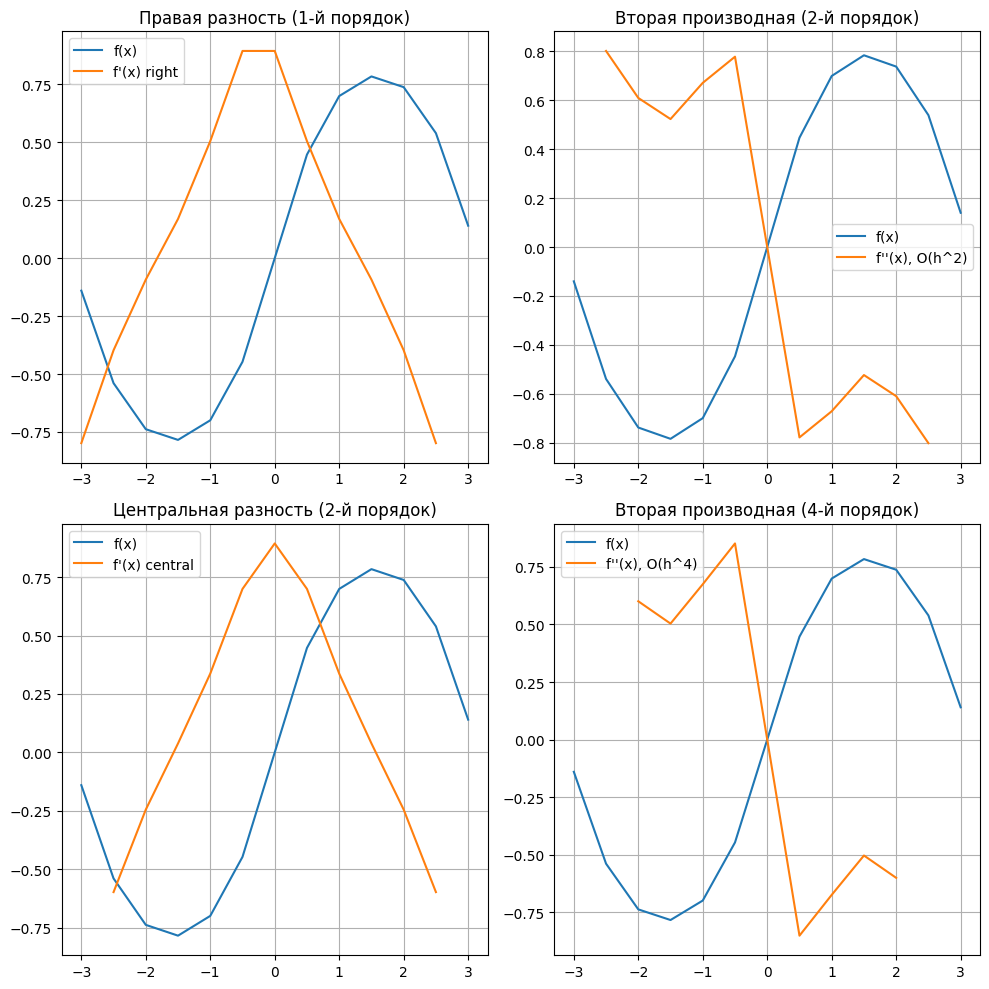

In [48]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(2, 2, figsize=(10, 10))

axis[0, 0].plot(grid, f(grid), label="f(x)")
axis[0, 0].plot(grid1, derivative1, label="f'(x) right")
axis[0, 0].set_title("Правая разность (1-й порядок)")
axis[0, 0].legend()
axis[0, 0].grid(True)

axis[1, 0].plot(grid, f(grid), label="f(x)")
axis[1, 0].plot(grid2, derivative2, label="f'(x) central")
axis[1, 0].set_title("Центральная разность (2-й порядок)")
axis[1, 0].legend()
axis[1, 0].grid(True)

axis[0, 1].plot(grid, f(grid), label="f(x)")
axis[0, 1].plot(grid3, derivative3, label="f''(x), O(h^2)")
axis[0, 1].set_title("Вторая производная (2-й порядок)")
axis[0, 1].legend()
axis[0, 1].grid(True)

axis[1, 1].plot(grid, f(grid), label="f(x)")
axis[1, 1].plot(grid4, derivative4, label="f''(x), O(h^4)")
axis[1, 1].set_title("Вторая производная (4-й порядок)")
axis[1, 1].legend()
axis[1, 1].grid(True)

plt.tight_layout()
plt.show()


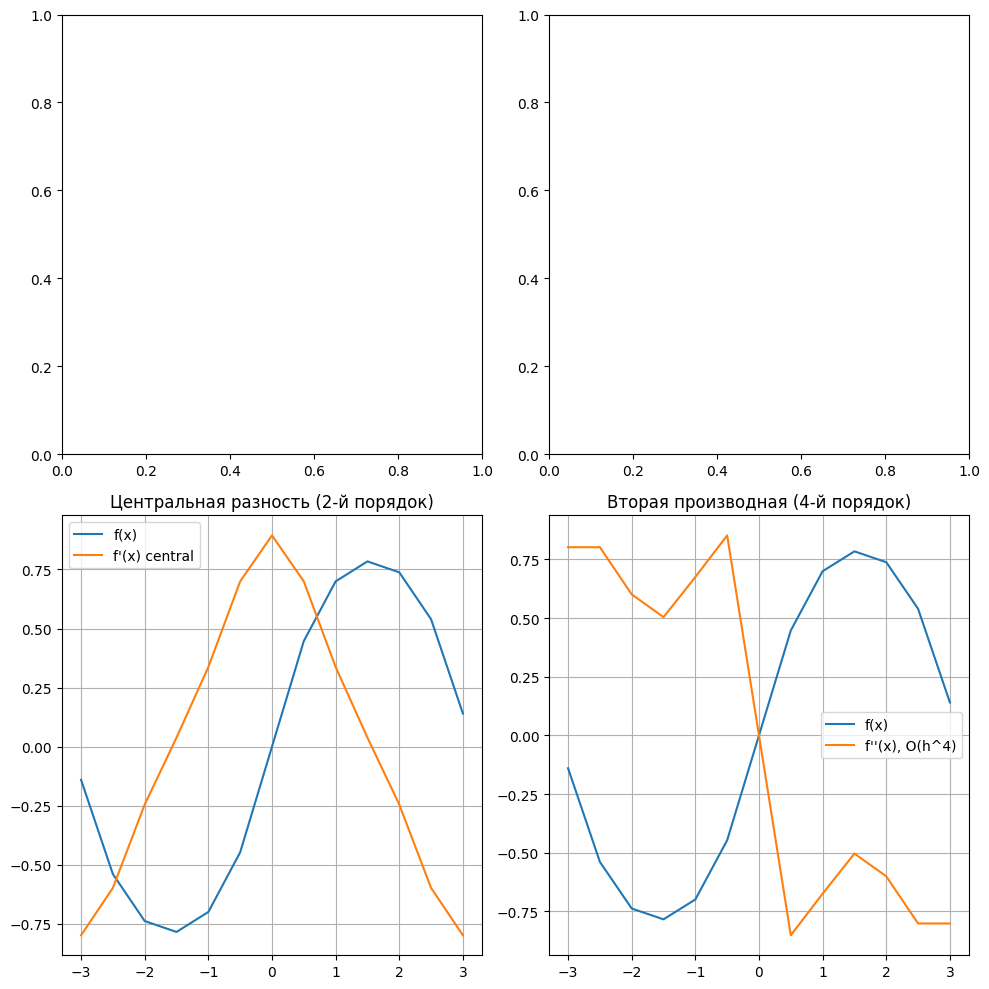

In [49]:
a, b = -3, 3
h = 0.5

def f(x: np.ndarray) -> np.ndarray:
    return np.atan(np.sin(x))

grid = np.arange(a, b + h, h, dtype=np.float64)

grid2, derivative2 = derivative(f, grid, 1, points=(1, 1))
grid4, derivative4 = derivative(f, grid, 2, points=(2, 2))

fig, axis = plt.subplots(2, 2, figsize=(10, 10))


axis[1, 0].plot(grid, f(grid), label="f(x)")
axis[1, 0].plot(grid2, derivative2, label="f'(x) central")
axis[1, 0].set_title("Центральная разность (2-й порядок)")
axis[1, 0].legend()
axis[1, 0].grid(True)


axis[1, 1].plot(grid, f(grid), label="f(x)")
axis[1, 1].plot(grid4, derivative4, label="f''(x), O(h^4)")
axis[1, 1].set_title("Вторая производная (4-й порядок)")
axis[1, 1].legend()
axis[1, 1].grid(True)

plt.tight_layout()
plt.show()